Importación de librerías
En esta celda importo todas las librerías necesarias para el análisis.

pandas y numpy para manipulación de datos

matplotlib y seaborn para visualizaciones

CountVectorizer para convertir texto en números

train_test_split para dividir los datos en entrenamiento y prueba

modelos Naive Bayes y métricas

pickle para guardar el modelo final

Esta celda prepara todo el entorno de trabajo para el proyecto.


In [40]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import pickle

sns.set(style="whitegrid")


2. Cargar dataset
Aquí cargo el archivo playstore_reviews.csv, que contiene las reseñas de usuarios.
Cada fila es una reseña y la columna polarity indica si el comentario es positivo (1) o negativo (0).
Luego visualizo las primeras filas para asegurarme de que se ha cargado correctamente.


In [41]:

import pandas as pd

# Opción 1: desde archivo local
df = pd.read_csv("playstore_reviews.csv")


df.head()



,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


3. limpieza basica de los datos.

En esta celda realizo una limpieza básica del texto para facilitar el análisis:

Paso todos los comentarios a minúsculas

Elimino espacios sobrantes

Elimino la columna package_name, ya que no aporta información útil para predecir el sentimiento

Elimino filas con valores nulos en la columna review

Esto me deja los textos listos para el siguiente paso.

In [42]:
# Información general del dataset
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


,polarity
count,891.000000
mean,0.344557
std,0.475490
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


EDA: información genera

In [43]:
# Revisar nulos
df.isnull().sum()


package_name    0
review          0
polarity        0
dtype: int64

No hay nulos

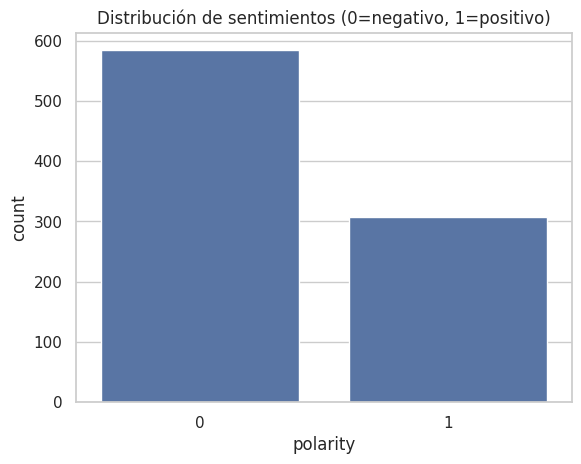

In [44]:
# Distribución de la variable objetivo (polarity)
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x="polarity")
plt.title("Distribución de sentimientos (0=negativo, 1=positivo)")
plt.show()


Esto es importante para saber si el dataset está balanceado.

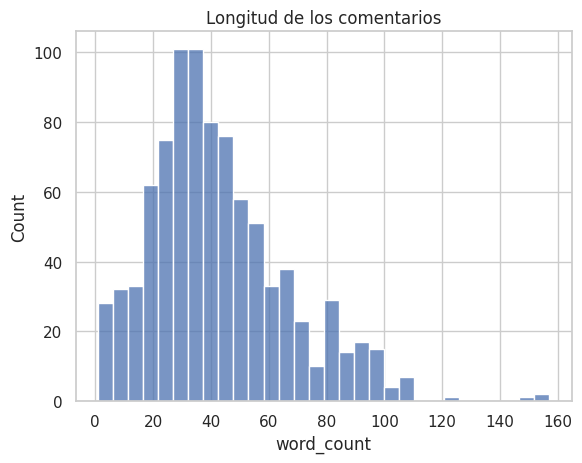

In [45]:
# Número de palabras por review
df["word_count"] = df["review"].apply(lambda x: len(str(x).split()))

sns.histplot(df["word_count"], bins=30)
plt.title("Longitud de los comentarios")
plt.show()


In [46]:
# Palabras más frecuentes
# Antes hay que limpiar texto:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english")
X_vec = vectorizer.fit_transform(df["review"])


In [47]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english")
X_vec = vectorizer.fit_transform(df["review"])

# Top palabras:
sum_words = X_vec.sum(axis=0)

words_freq = [
    (word, int(sum_words[0, idx]))
    for word, idx in vectorizer.vocabulary_.items()
]

words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
words_freq[:20]


[('app', 430),
 ('update', 187),
 ('game', 171),
 ('fix', 144),
 ('new', 142),
 ('good', 141),
 ('like', 139),
 ('use', 132),
 ('ŕľ', 131),
 ('great', 129),
 ('time', 123),
 ('just', 119),
 ('don', 109),
 ('browser', 100),
 ('phone', 93),
 ('really', 86),
 ('doesn', 83),
 ('work', 81),
 ('version', 78),
 ('love', 78)]

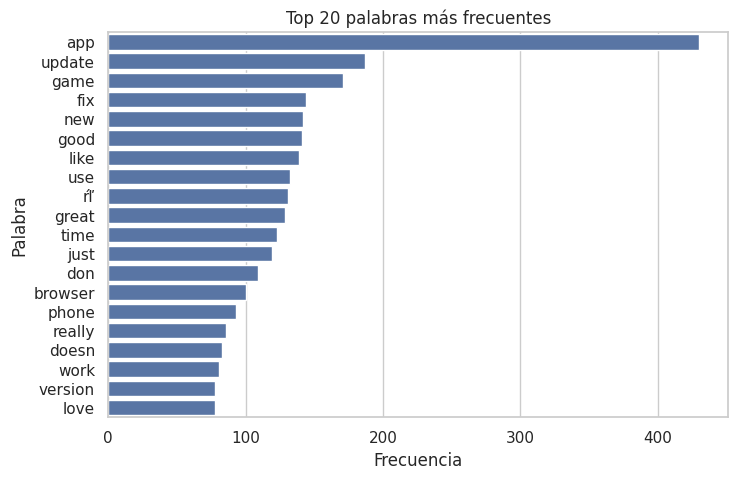

In [48]:
top_words = words_freq[:20]
words = [w[0] for w in top_words]
counts = [w[1] for w in top_words]

plt.figure(figsize=(8,5))
sns.barplot(x=counts, y=words)
plt.title("Top 20 palabras más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()



In [49]:
# Comparar palabras entre positivas y negativas
df_pos = df[df["polarity"]==1]
df_neg = df[df["polarity"]==0]

vectorizer_pos = CountVectorizer(stop_words="english")
X_pos = vectorizer_pos.fit_transform(df_pos["review"])

vectorizer_neg = CountVectorizer(stop_words="english")
X_neg = vectorizer_neg.fit_transform(df_neg["review"])


In [50]:
# Top palabras positivas:
sum_words_pos = X_pos.sum(axis=0)
words_freq_pos = [(word, sum_words_pos[0, idx]) for word, idx in vectorizer_pos.vocabulary_.items()]
sorted(words_freq_pos, key=lambda x: x[1], reverse=True)[:15]


[('app', np.int64(157)),
 ('ŕľ', np.int64(114)),
 ('game', np.int64(91)),
 ('great', np.int64(87)),
 ('good', np.int64(71)),
 ('love', np.int64(56)),
 ('like', np.int64(53)),
 ('žŕ', np.int64(52)),
 ('use', np.int64(47)),
 ('best', np.int64(45)),
 ('browser', np.int64(42)),
 ('really', np.int64(39)),
 ('just', np.int64(38)),
 ('new', np.int64(29)),
 ('apps', np.int64(28))]

In [51]:
# Top negativas:
sum_words_neg = X_neg.sum(axis=0)
words_freq_neg = [(word, sum_words_neg[0, idx]) for word, idx in vectorizer_neg.vocabulary_.items()]
sorted(words_freq_neg, key=lambda x: x[1], reverse=True)[:15]


[('app', np.int64(273)),
 ('update', np.int64(164)),
 ('fix', np.int64(130)),
 ('new', np.int64(113)),
 ('time', np.int64(99)),
 ('like', np.int64(86)),
 ('don', np.int64(85)),
 ('use', np.int64(85)),
 ('just', np.int64(81)),
 ('game', np.int64(80)),
 ('doesn', np.int64(78)),
 ('phone', np.int64(76)),
 ('good', np.int64(70)),
 ('version', np.int64(65)),
 ('google', np.int64(65))]